# **ELEMENTOS FINITOS OLVER**

## **Ejemplo 14.9**

El método de elementos finitos también se puede aplicar a ecuaciones de Poisson en dos dimensiones, el texto de Olver se centra en problemas de condición de frontera de Dirichlet. La principal dificultad de estos problemas es que al dividir el dominio $\Omega$ hay mucha más libertad, y no es siempre posible partirlo uniformemente.  Para esto, se divide $\Omega$ escogiendo una triangulación dada por un conjunto finito de nodos en el dominio. En el ejemplo que implementamos el dominio es una región formada por un rectangulo de 2 metros de ancho y 1 de alto y al que se le agregan dos semicircunferencias a los lado. El texto nos da la siguiente triangulación:

In [ ]:
import sys
!{sys.executable} -m pip install --user numpy
!{sys.executable} -m pip install --user matplotlib

#Importamos las Librerías Necesarias
from IPython.display import display, Image
import matplotlib.pyplot as plt 
import matplotlib.tri as mtri
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

#Personalizamos las opciones de impresión de matrices
np.set_printoptions(suppress=True, precision=4, threshold=sys.maxsize)

El problema que consideramos consiste en encontrar la temperatura de equilibrio del  plato ovalado cuando se expone a una temperatura de -10 grados en el borde semicircular izquierdo,  10 grados en el borde semicircular derecho, y en los bordes rectos la temperartura varia linealmente de -10 a 10 grados. El espacio de dimensión finita al que queremos restringir nuestro problema es el de las funciones continuas afines a trozos que satisfacen las condiciones de frontera y tales que en cada triangulo son planas. la dimensión de este espacio será el numero de nodos de la triangulación y una base para dicha triangulación estará formada por las funciones piramide:

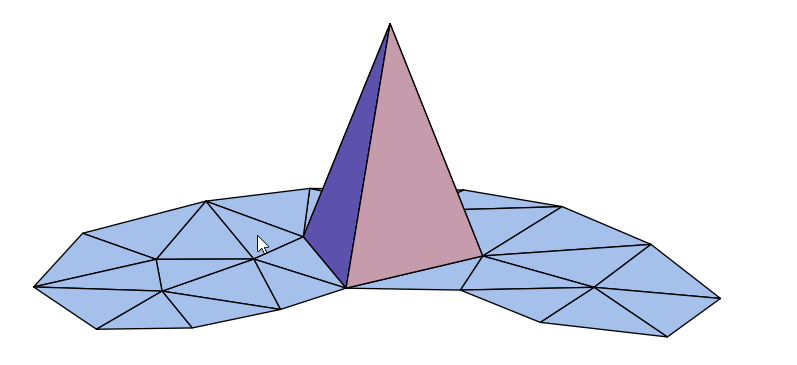

In [113]:
display(Image(filename='img/hat_3d.png'))

que satisfacen:

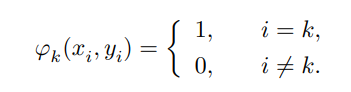

In [125]:
display(Image(filename='img/base_149.png'))

Notemos que como en este caso tenemos una ecuación no homogenea, debemos tener en
cuenta los vertices en la frontera también. De esta forma cada función en el epacio será de la
forma

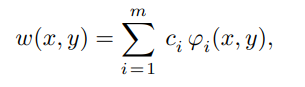

In [126]:
display(Image(filename='img/1454.png'))

y para cada $\mathrm{x}_{j}=(x_{j},y_{j})$ en la frontera tendremos:

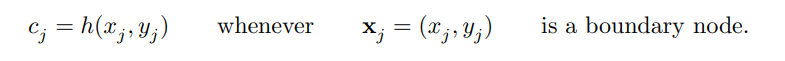

In [127]:
display(Image(filename='img/1455.png'))


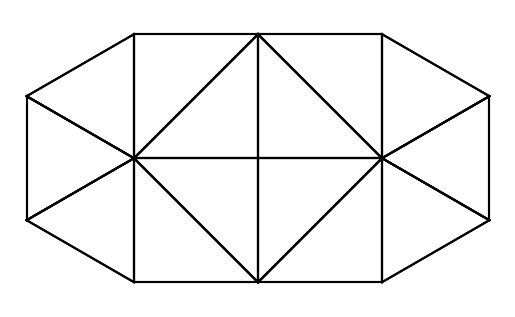

In [58]:
def pointsCoordenates():
    #Hacemos una lista con las coordenas de los puntos y cada una de las triangulaciones
    points = []
    triangles = []

    point1 = [0, 0.5]
    point2 = [0.5, 0.5]
    point3 = [1.0, 0.5]
    point4 = [0.5, 1.0]
    point5 = [0, 1.0]
    point6 = [(-(0.25*np.sqrt(3))), 0.75]
    point7 = [(-(0.25*np.sqrt(3))), 0.25]
    point8 = [0, 0]
    point9 = [0.5, 0]
    point10 = [1.0, 0]
    point11 = [1.0 + (0.25*np.sqrt(3)), 0.25]
    point12 = [1.0 + (0.25*np.sqrt(3)), 0.75]
    point13 = [1.0, 1.0]

    triangle1 = [1,5,6]
    triangle2 = [1,6,7]
    triangle3 = [1,7,8]
    triangle4 = [1,5,4]
    triangle5 = [1,2,4]
    triangle6 = [2,3,4]
    triangle7 = [3,4,13]
    triangle8 = [1,8,9]
    triangle9 = [1,2,9]
    triangle10 = [2,3,9]
    triangle11 = [3,9,10]
    triangle12 = [3,12,13]
    triangle13 = [3,11,12]
    triangle14 = [3,11,10]

    for i in range(1,14):
         points.append(eval("point" + str(i)))
    
    for i in range(1,15):
         triangles.append(eval("triangle" + str(i)))

    return points, triangles
    
def graphPoints(points, triangles):
     for triangle in triangles:
          for point1 in triangle:
               for point2 in triangle:
                    coordpoint1 = points[point1 - 1]
                    coordpoint2 = points[point2 - 1]

                    x_values = [coordpoint1[0], coordpoint2[0]]
                    y_values = [coordpoint1[1], coordpoint2[1]]

                    plt.plot(x_values, y_values, color="black")



     plt.xlim(-0.5, 1.5)
     plt.ylim(-0.1, 1.1)
     plt.gca().set_aspect('equal', adjustable='box')
     plt.axis('off')
     plt.show()

     return None

def getAngles(points, triangles):
    #Obtenemos los ángulos de las triangulaciones

    triangle_angles = []
    for triangle in triangles:
        angles = []
        for i, point_index in enumerate(triangle):
            point = points[point_index - 1]
            if i == 0:
                pointa = points[triangle[1]-1]
                pointc = points[triangle[2]-1]
            
            if i == 1:
                pointa = points[triangle[0]-1]
                pointc = points[triangle[2]-1]

            if i == 2:
                pointa = points[triangle[0]-1]
                pointc = points[triangle[1]-1]

            a = np.array(pointa)
            b = np.array(point)
            c = np.array(pointc)

            ba = a - b
            bc = c - b

            cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))

            angle = np.arccos(cosine_angle)
            angle = round(np.degrees(angle))
            

            angles.append(angle)

        triangle_angles.append(angles)
    
    return triangle_angles

points = pointsCoordenates()[0]
triangles = pointsCoordenates()[1]

graphPoints(points, triangles)



                    


Para hallar los coeficientes $c_{j}$ para los nodos interiores del dominio debemos construir la matriz $K*$ que será igual a $K_{1}+K_{2}+...+K_{14}$, donde la matriz $K_{v}$ está construida a partir de los nodos del triangulo $v$ de la triangulación (enumerados como aparecen arriba) y se hace de la siguiente forma, si $i,j,k$ son los nodos del triangulo $v$, y $\theta_{i},\theta_{j},\theta_{k}$ los angulos correspondientes a cada nodo, entonces:

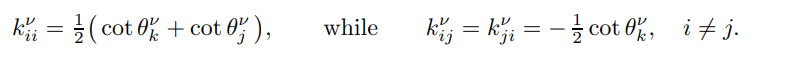

In [128]:
display(Image(filename='img/1444.png'))

In [109]:
points = pointsCoordenates()[0]
triangles = pointsCoordenates()[1]
angles = getAngles(points, triangles)



def KStar(points, triangles, angles):
    #Con las formulas dadas para calcular las entradas de la matriz k de cada triangulacion corremos el siguiente algoritmo
    K_matrix = np.zeros((len(points), len(points)))

    for v, triangle in enumerate(triangles):
        K_triangle = np.zeros((len(points), len(points)))

        for i, point_index_i in enumerate(triangle):
            for j, point_index_j in enumerate(triangle): 
                #Para el caso del mismo índice con la suma de las cotangentes
                if i == j:
                    if i == 0:
                        angle_1 = 1/np.tan(np.radians(angles[v][1])) 
                        angle_2 = 1/np.tan(np.radians(angles[v][2])) 
                        k_entry = 0.5*(angle_1 + angle_2)
                        K_triangle[point_index_i-1,point_index_j-1] = k_entry

                    if i == 1:
                        angle_1 = 1/np.tan(np.radians(angles[v][0])) 
                        angle_2 = 1/np.tan(np.radians(angles[v][2])) 
                        k_entry = 0.5*(angle_1 + angle_2)
                        K_triangle[point_index_i-1,point_index_j-1] = k_entry

                    if i == 2:
                        angle_1 = 1/np.tan(np.radians(angles[v][1])) 
                        angle_2 = 1/np.tan(np.radians(angles[v][0])) 
                        k_entry = 0.5*(angle_1 + angle_2)
                        K_triangle[point_index_i-1,point_index_j-1] = k_entry
                else:
                    for m in range(3):
                        if (m != i) and (m != j) :
                            #Para distintos índices con la cotangente del opuesto
                            angle = 1/np.tan(np.radians(angles[v][m])) 
                            k_entry = (-1/2)*(angle)
                            K_triangle[point_index_i-1,point_index_j-1] = k_entry
                            K_triangle[point_index_j-1,point_index_i-1] = k_entry
                
            
        K_matrix += K_triangle
    
    return K_matrix  

def KMatrix(K_matrix):
    #Obtenemos la submatriz 3x3
    K_star = K_matrix[0:3, 0:3]
    return K_star

def KTilde(K_matrix):
    #Obtenemos la matriz restante de las tres primeras filas de la anterior
    K_star = K_matrix[0:3, 3:14]
    return K_star


K_star = KStar(points, triangles, angles)
K_matrix = KMatrix(K_star)
K_tilde = KTilde(K_star)

print('K = ')
print(K_matrix)

print('')

print('K_tilde = ')
print(K_tilde)

print('')

print('K_star = ')
print(K_star)






K = 
[[ 3.7321 -1.      0.    ]
 [-1.      4.     -1.    ]
 [ 0.     -1.      3.7321]]

K_tilde = 
[[-0.     -0.7887 -0.5774 -0.5774 -0.7887 -0.      0.      0.      0.
   0.    ]
 [-1.      0.      0.      0.      0.     -1.      0.      0.      0.
   0.    ]
 [-0.      0.      0.      0.      0.     -0.     -0.7887 -0.5774 -0.5774
  -0.7887]]

K_star = 
[[ 3.7321 -1.      0.     -0.     -0.7887 -0.5774 -0.5774 -0.7887 -0.
   0.      0.      0.      0.    ]
 [-1.      4.     -1.     -1.      0.      0.      0.      0.     -1.
   0.      0.      0.      0.    ]
 [ 0.     -1.      3.7321 -0.      0.      0.      0.      0.     -0.
  -0.7887 -0.5774 -0.5774 -0.7887]
 [-0.     -1.     -0.      2.     -0.5     0.      0.      0.      0.
   0.      0.      0.     -0.5   ]
 [-0.7887  0.      0.     -0.5     1.5774 -0.2887  0.      0.      0.
   0.      0.      0.      0.    ]
 [-0.5774  0.      0.      0.     -0.2887  1.1547 -0.2887  0.      0.
   0.      0.      0.      0.    ]
 [-0.5774  0

Como en este problema solo necesitamos saber los coeficientes $c_{j}$ de los nodos interiores 1,2 y 3, entonces consideramos la submatriz 3x3 $K$ de $K*$ formada por el bloque 3x3 superior izquierdo, pero como tenemos que tener en cuenta las condiciones de frontera no homogeneas, también debemos considerar la submatriz $\tilde{K}$ 3x10 de $K*$, formada por el bloque 3x10 superior derecho y el sistema que debemos solucionar es:

$$Kc+\tilde{K}h=b$$

donde $b$ es el vector de 3 componentes que se define por:

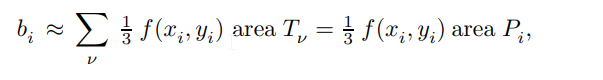

In [129]:
display(Image(filename='img/1452.png'))

y como en este caso el calor interior es 0, entonces b es el vector 0, y $h$ es el vector de tamaño 10 dado por:


$$h=(0,-10,-10,-10,-10,0,10,10,10,10)$$

Que indica el calor en los nodos de la frontera del 4 al 13. Por lo tanto nuestro sistema
lineal quedaría

$$Kc=-\tilde{K}h$$

Y la solución $(c_{1},c_{2},c_{3})$ nos indica los coeficientes de los vertices interiores. Estos son los resultados que obtuvimos:

In [110]:

def h_vector():
    #Creamos el vector h
    h = [0,-10,-10,-10,-10,0,10,10,10,10]
    h = np.array(h)
    h = np.transpose(np.matrix(h))
    return h 

h = h_vector()

def c_vector(K_matrix, K_tilde, h_vector):
    #Resolvemos el sistema de ecuaciones enunciado

    K_inverse = np.linalg.inv(K_matrix)
    c = (K_inverse.dot(K_tilde)).dot(h_vector)
    c = (-1)*c
    c = np.transpose(c)

    return c

print(c_vector(K_matrix, K_tilde, h))




[[-7.3205  0.      7.3205]]


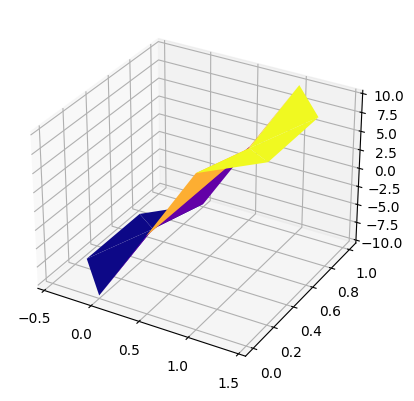

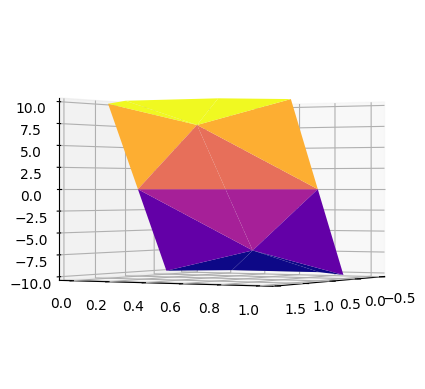

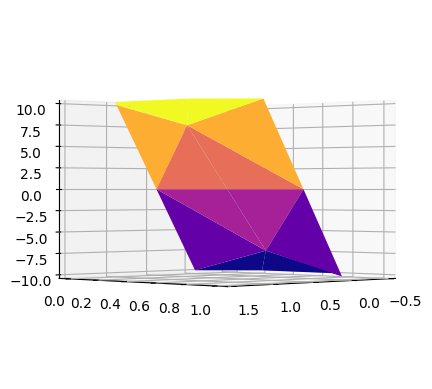

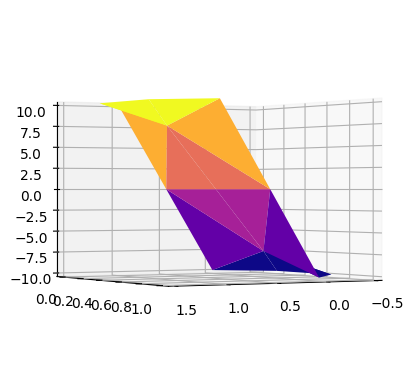

In [124]:
c = c_vector(K_matrix, K_tilde, h)

def surfaceFig(h, c, points, triangles):
    h = np.transpose(h)
    h = h.tolist()
    h = h[0]
    c = c.tolist()
    c = c[0]
    z = c + h
    my_cmap = plt.get_cmap('plasma')

    modify_triangles = []
    for triangle in triangles:
        modify_triangle = []
        for point in triangle:
            modify_triangle.append(point - 1)
        modify_triangles.append(modify_triangle)

    xy = np.array(points)

    triang = mtri.Triangulation(xy[:,0], xy[:,1], triangles=modify_triangles)
    fig, ax = plt.subplots(subplot_kw =dict(projection="3d", adjustable='box'))
    ax.plot_trisurf(triang, z, cmap = my_cmap)
    plt.show()

    triang = mtri.Triangulation(xy[:,0], xy[:,1], triangles=modify_triangles)
    fig, ax = plt.subplots(subplot_kw =dict(projection="3d", adjustable='box'))
    ax.view_init(0, 30)
    ax.plot_trisurf(triang, z, cmap = my_cmap)
    plt.show()

    triang = mtri.Triangulation(xy[:,0], xy[:,1], triangles=modify_triangles)
    fig, ax = plt.subplots(subplot_kw =dict(projection="3d", adjustable='box'))
    ax.plot_trisurf(triang, z, cmap = my_cmap)
    ax.view_init(0, 45)
    plt.show()

    triang = mtri.Triangulation(xy[:,0], xy[:,1], triangles=modify_triangles)
    fig, ax = plt.subplots(subplot_kw =dict(projection="3d", adjustable='box'))
    ax.plot_trisurf(triang, z, cmap = my_cmap)
    ax.view_init(0, 60)
    plt.show()

    return None

(surfaceFig(h,c, points, triangles))